In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
from scipy import stats
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

/Users/kelu/anaconda3/envs/bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=True).eval()

In [3]:
def get_embedding(text, tokenizer, model):
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    with torch.no_grad():
        outputs = model(tokens_tensor)
        hidden_states = outputs[2]
        token_vecs = hidden_states[-2][0]
        embedding = torch.mean(token_vecs, dim=0)
    return embedding.numpy()

In [22]:
file_path = 'dataset/thermoelectric_dft/'
file_name = 'dft.txt'

In [23]:
df = pd.read_csv(file_path + file_name, sep='\t', header=None, names=['name', 'value'])

In [24]:
thermoelectric_embedding = get_embedding("thermoelectric", tokenizer, model)

def compute_similarities_and_ranks(df):
    df['similarity'] = df['name'].apply(lambda x: 1 - cosine(get_embedding(x, tokenizer, model), thermoelectric_embedding))
    df['value_rank'] = df['value'].rank(ascending=False)
    df['similarity_rank'] = df['similarity'].rank(ascending=False)
    return df

In [25]:
df = compute_similarities_and_ranks(df)

In [26]:
df.to_csv(file_path + 'bert_' + file_name, encoding='utf-8', index=False)

In [ ]:
print(df[['name', 'value_rank', 'similarity_rank']])

In [27]:
res = stats.spearmanr(df['value_rank'], df['similarity_rank'])
res.statistic

-0.0383488945022673

<Axes: xlabel='name'>

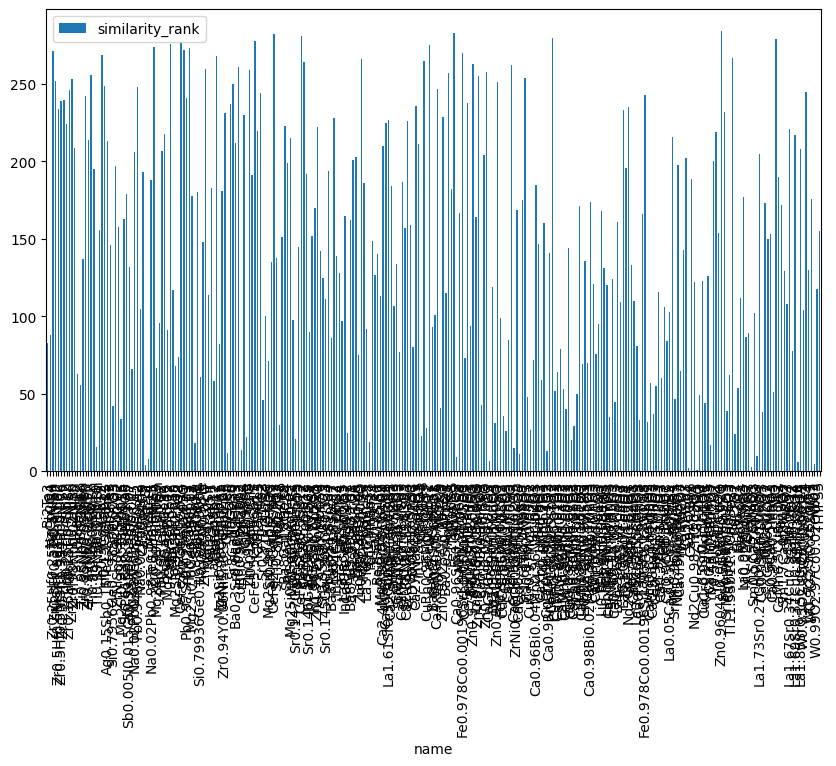

In [13]:
df.plot(x='name', y='similarity_rank', kind='bar', figsize=(10, 6))

experiment_pf: -0.23467405965864976

experiment_zt: -0.2855201013349994

dft: -0.0383488945022673